# SLAM experiments

In [1]:
# Importing the libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.image as mpimg
import cv2
import time
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from scipy.spatial import Delaunay

# Plotting settings
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

## The setup

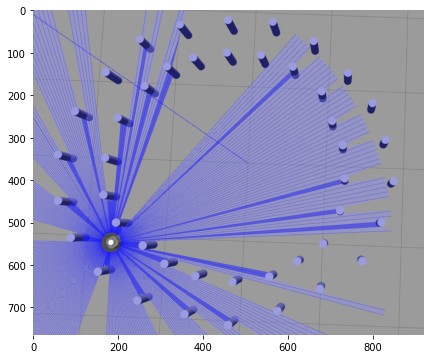

In [2]:
# Show the image
img = mpimg.imread('/home/valigatotus/Documents/github/LiDAR-FSAE/docu/hidden/MAP/round_circuit.png')
plt.imshow(img)

## Loading map

In [3]:
# Loading the map from a pickle file
with open('../../cone_mapper/map_data2.pickle', 'rb') as f:
    map_data = pickle.load(f)

# Map parameters
resolution, xorigin, yorigin = 0.05000000074505806, -0.803898811340332, -1.9500000000000002
extent=[xorigin, xorigin + map_data.shape[1]*resolution, yorigin, yorigin + map_data.shape[0]*resolution]


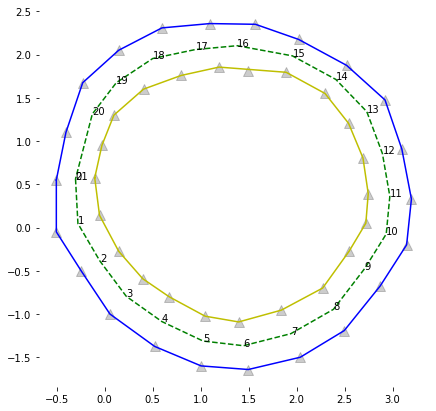

In [4]:
def find_cone_centroids(map_data, resolution=0.05, xorigin=0, yorigin=0, threshold=42, white=101):
    map_data = cv2.threshold(map_data.astype(np.uint8), threshold, white, cv2.THRESH_BINARY)[1]

    
    contours, hierarchy = cv2.findContours(map_data, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1:]

    centroids = [(cv2.minEnclosingCircle(cnt)[0][0] * resolution + xorigin,
                  cv2.minEnclosingCircle(cnt)[0][1] * resolution + yorigin) for cnt in contours]

    return centroids

def find_lanes(centroids):
    # finding the centroids that are on the left and right side of the track

    centroids = np.array(centroids) # converting centroids list to numpy array
    distances = cdist(centroids, centroids)
    np.fill_diagonal(distances, np.inf) # setting the diagonal elements to a very large value to avoid connecting a centroid to itself
    
    hull_all = ConvexHull(centroids) # first convex hull with all the centroids to find the outermost points
    hull_indices_all = hull_all.vertices.tolist() # getting the indices of the points that form the convex hull
    hull_indices_all.append(hull_indices_all[0]) # add the first point to the end to close the loop
    
    remaining_indices = np.setdiff1d(np.arange(len(centroids)), hull_indices_all[:-1]) # get the indices of the points not included in the first convex hull
    hull_remaining = ConvexHull(centroids[remaining_indices]) # second convex hull with the remaining centroids
    hull_indices_remaining = remaining_indices[hull_remaining.vertices].tolist() # getting the indices of the points that form the second convex hull
    hull_indices_remaining.append(hull_indices_remaining[0]) # adding the first point to the end to close the loop

    return hull_indices_all, hull_indices_remaining # returning the indices of the centroids that form the left and right lanes

# calculating the centerline
def calc_centerline(centroids, ll_indices, rl_indices):
    centerline = []
    range_ = len(rl_indices) if len(rl_indices) <= len(ll_indices) else len(ll_indices)
    for i in range(range_ - 1):
        p1 = np.array(centroids[rl_indices[i]])
        p2 = np.array(centroids[ll_indices[i]])
        centerline.append((p1 + p2) / 2)
    # close the loop
    centerline.append(centerline[0])

    return centerline

def plot_track(map_data, resolution=0.05, xorigin=0, yorigin=0, threshold=42, white=101):
    centroids = find_cone_centroids(map_data.copy(), resolution, xorigin, yorigin)
    ll_indices, rl_indices = find_lanes(centroids)
    centerline = calc_centerline(centroids, rl_indices, ll_indices)

    # plot the centroids
    plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], s=100, c='k', marker='^', alpha=0.2)
    # plot the left lane
    plt.plot(np.array(centroids)[ll_indices, 0], np.array(centroids)[ll_indices, 1], c='b')
    # plot the right lane
    plt.plot(np.array(centroids)[rl_indices, 0], np.array(centroids)[rl_indices, 1], c='y')
    # plot the centerline
    plt.plot(np.array(centerline)[:, 0], np.array(centerline)[:, 1], 'g--')
    for i, txt in enumerate(range(len(centerline))):
        plt.annotate(txt, (centerline[i][0], centerline[i][1]))
    plt.show()


plot_track(map_data, resolution, xorigin, yorigin)


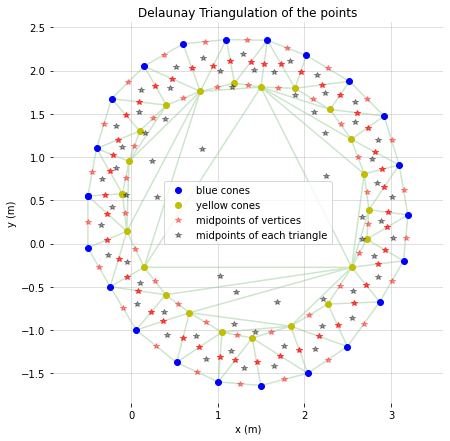

In [5]:
centroids = find_cone_centroids(map_data.copy(), resolution, xorigin, yorigin)
ll_indices, rl_indices = find_lanes(centroids)
rl_indices = np.insert(rl_indices, 0, 8)
points = np.array(centroids[:])

# Performing Delaunay triangulation
tri = Delaunay(points)
# Voronoi diagram
# vor = Voronoi(points)


fig, ax = plt.subplots()

# # Plott voronoi diagram
# voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='k', line_width=1, line_alpha=0.2, point_size=2)
# Plotting left lane points
ax.plot(points[ll_indices, 0], points[ll_indices, 1], 'bo', label='blue cones')
# Plotting right lane points
ax.plot(points[rl_indices, 0], points[rl_indices, 1], 'yo', label='yellow cones')
# Plotting the Delaunay triangulation
ax.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'g-', alpha=0.2)

# Calculate the midpoints of the internal edges and not those within 2 left lane points or 2 right lane points
midpoints = []
for i in range(len(tri.simplices)):
    if not (np.all(np.isin(tri.simplices[i], ll_indices)) or np.all(np.isin(tri.simplices[i], rl_indices))):
        midpoints.append((points[tri.simplices[i][0]] + points[tri.simplices[i][1]]) / 2)
        midpoints.append((points[tri.simplices[i][1]] + points[tri.simplices[i][2]]) / 2)
        midpoints.append((points[tri.simplices[i][2]] + points[tri.simplices[i][0]]) / 2)

# Calculate the midpoints of each triangle
midpoints2 = []
for i in range(len(tri.simplices)):
    midpoints2.append((points[tri.simplices[i][0]] + points[tri.simplices[i][1]] + points[tri.simplices[i][2]]) / 3)

# Plotting the midpoints
ax.plot(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], 'r*', label='midpoints of vertices', alpha=0.4)

# Plotting the midpoints of each triangle
ax.plot(np.array(midpoints2)[:, 0], np.array(midpoints2)[:, 1], 'k*', label='midpoints of each triangle', alpha=0.4)

ax.set_title('Delaunay Triangulation of the points')
ax.grid(True, alpha=0.5)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')


plt.axis('equal')
plt.legend()
plt.show()

# save figure in high resolution
fig.savefig('delaunay.png', dpi=300)

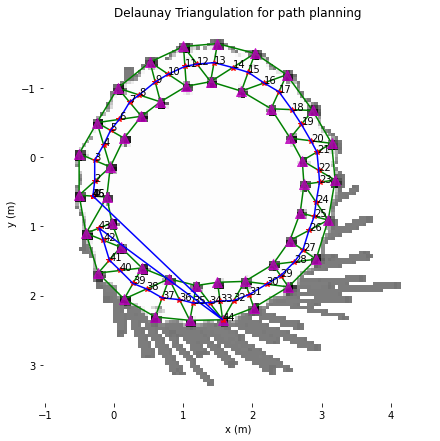

<Figure size 504x504 with 0 Axes>

In [305]:
# Performing Delaunay triangulation
tri = Delaunay(points)

# remove the triangles that are formed by three left lane points or three right lane points
for i in range(len(tri.simplices)):
    if np.all(np.isin(tri.simplices[i], ll_indices)) or np.all(np.isin(tri.simplices[i], rl_indices)):
        tri.simplices[i] = np.array([0, 0, 0])

# Calculate the midpoints of the triangles vertices and triangles
midpoints = []
midpoints2 = []
for i in range(len(tri.simplices)):
    if len(np.intersect1d(ll_indices, tri.simplices[i][:2])) == 1:
        midpoints.append((points[tri.simplices[i][0]] + points[tri.simplices[i][1]]) / 2)
    if len(np.intersect1d(ll_indices, tri.simplices[i][1:])) == 1:
        midpoints.append((points[tri.simplices[i][1]] + points[tri.simplices[i][2]]) / 2)

    midpoints2.append((points[tri.simplices[i][0]] + points[tri.simplices[i][1]] + points[tri.simplices[i][2]]) / 3)
    

# Remove duplicates
midpoints = np.unique(midpoints, axis=0)
midpoints2 = np.unique(midpoints2, axis=0)

# Sort the midpoints using the nearest neighbor algorithm
def nearest_neighbor(points, start_point=None):
    """Order a set of points using the nearest neighbor algorithm."""
    ordered_points = []
    # Choose a random starting point
    current_point = points[0]
    if start_point is not None:
        current_point = start_point
    points = np.array(points)
    # points = np.delete(points, 0, axis=0)
    ordered_points.append(current_point)
    while points.shape[0] > 0:
        # Calculate distances to all other points
        distances = cdist([current_point], points)[0]
        # Choose the closest point as the next point in the sequence
        min_distance_index = np.argmin(distances)
        current_point = points[min_distance_index]
        points = np.delete(points, min_distance_index, axis=0)
        ordered_points.append(tuple(current_point))
    # Add the starting point to the end to complete the loop
    ordered_points.append(ordered_points[0])
    return ordered_points

midpoints = nearest_neighbor(midpoints)
midpoints2 = nearest_neighbor(midpoints2)
# Closing the loop
midpoints.append(midpoints[0])
# Removing the 44th point (error)
midpoints = np.delete(midpoints, 44, axis=0)

# Plotting map data 
plt.imshow(map_data, cmap='gray', extent=[xorigin, xorigin + map_data.shape[1] * resolution, yorigin + map_data.shape[0] * resolution, yorigin])

# Plotting triangulation
plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'g-')

# Plotting the centroids
plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], s=100, c='m', marker='^', alpha=0.8)

# Plotting the midpoints
plt.plot(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], 'r*', label='midpoints')

# Numbering the midpoints by their indices
for i, txt in enumerate(range(len(midpoints))):
    plt.annotate(txt, (midpoints[i][0], midpoints[i][1]))

# Plotting polyline through the midpoints
plt.title('Delaunay Triangulation for path planning')
plt.plot(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], 'b-', label='polyline')

# # Plotting polyline through the midpoints2
# plt.plot(np.array(midpoints2)[:, 0], np.array(midpoints2)[:, 1], 'k-', label='polyline2')

# Plot metadata
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

# save the plot in high resolution
plt.savefig('delaunay2.png', dpi=300)

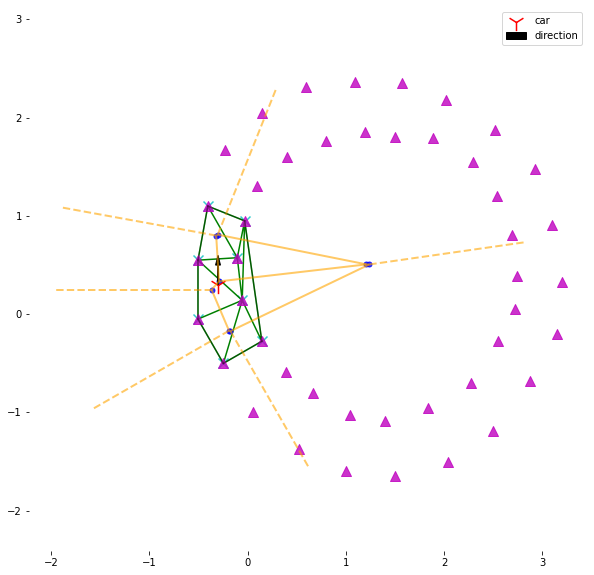

In [172]:
origin = (-0.3, 0.3)
direction = np.deg2rad(90)
points = np.array(centroids)
line_length = 0.4


# calculate the  2 points that are +90 and -90 degrees from the direction at the origin
line = np.array([[origin[0] + line_length * np.cos(direction + np.pi / 2), origin[1] + line_length * np.sin(direction + np.pi / 2)],
                [origin[0] - line_length * np.cos(direction + np.pi / 2), origin[1] + line_length * np.sin(direction + np.pi / 2)]])

# find the 4 closest points to the line in the unit direction
distances = cdist(line, points)[0]
closest_indices = np.argsort(distances)[:8]
closest_points = points[closest_indices]

# compute delaunay triangulation of the closest points
tri = Delaunay(closest_points)

# convex hull 
hull = ConvexHull(closest_points)

# voronoi diagram
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(closest_points)

# calculate the midpoints of the delaunay lines, do not include incclude the midpoints that are already in the array
midpoints = []
for i in range(len(tri.simplices)):
    midpoints.append((closest_points[tri.simplices[i][0]] + closest_points[tri.simplices[i][1]]) / 2)
    midpoints.append((closest_points[tri.simplices[i][1]] + closest_points[tri.simplices[i][2]]) / 2)
    midpoints.append((closest_points[tri.simplices[i][2]] + closest_points[tri.simplices[i][0]]) / 2)

# remove duplicates
midpoints = np.unique(midpoints, axis=0)


# calculate the midpoints that is the closest to the origin
distances = cdist([origin], midpoints)[0]
closest_indices = np.argsort(distances)[:2]
closest_midpoints = np.array(midpoints)[closest_indices]

# use voronoi diagram to find the left and right cones based on the medial axis
# left cone
# plot the voronoi diagram
voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

# plot the tree
# plt.scatter(tree.data[:, 0], tree.data[:, 1], s=100, c='r', marker='x', alpha=0.8)

# plot closest midpoints
# plt.scatter(closest_midpoints[:, 0], closest_midpoints[:, 1], s=100, c='r', marker='^', alpha=0.8)

# plot midpoints
# plt.scatter(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], s=100, c='purple', marker='.')

# plot the closest points
plt.scatter(closest_points[:, 0], closest_points[:, 1], s=100, c='c', marker='x', alpha=0.8)

# plot the perpendicular line
# plt.plot(line[:, 0], line[:, 1], 'k-', label='perpendicular line')

# plot the delaunay triangulation
plt.triplot(closest_points[:, 0], closest_points[:, 1], tri.simplices.copy(), 'g-')

# plot the vortri vertices
plt.scatter(vor.vertices[:, 0], vor.vertices[:, 1], s=100, c='b', marker='.', alpha=0.8)

# plot the convex hull
for simplex in hull.simplices:
    plt.plot(closest_points[simplex, 0], closest_points[simplex, 1], 'k-', alpha=0.3)

# plt.plot(xp, p(xp), 'r--', label='polynomial')

# plot the cones
plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], s=100, c='m', marker='^', alpha=0.8)
plt.scatter(origin[0], origin[1], s=300, c='r', marker='1', label='car')
plt.arrow(origin[0], origin[1], 0.2 * np.cos(direction), 0.2 * np.sin(direction), head_width=0.05, head_length=0.1, fc='k', ec='k', label='direction')
plt.axis('equal')
# make plot bigger
plt.gcf().set_size_inches(10, 10)
plt.legend()

In [317]:
def sort_by_nnb(points, start_point=None):
    """Order a set of points using the nearest neighbor algorithm."""
    ordered_points = []
    points = np.array(points)
    current_point = start_point
    while points.shape[0] > 0:
        # Calculate distances to all other points
        distances = cdist([current_point], points)[0]
        # Choose the closest point as the next point in the sequence
        min_distance_index = np.argmin(distances)
        current_point = points[min_distance_index]
        points = np.delete(points, min_distance_index, axis=0)
        ordered_points.append(tuple(current_point))
    return ordered_points

In [173]:
len(closest_points)

8

In [251]:
def find_lr_indices(points: np.ndarray):

    x1, y1 = 0.1, -0.5
    x2, y2 = 0, -0.4
    plt.plot([x1, x2], [y1, y2], 'ko-', alpha=0.7)  # plot origin line

    path = np.array([[x1, y1], [x2, y2]], dtype=np.float32, ndmin=2)

    for i in range(3):
        x1, y1 = path[-2, 0], path[-2, 1]
        x2, y2 = path[-1, 0], path[-1, 1]

        # angle formed by x1, y1, x2, y2
        angle1 = np.arctan2(y2 - y1, x2 - x1)

        # find the 3 closest points to the last point in the path
        distances = cdist(path[-1:], points)[0]
        closest_indices = np.array(np.argsort(distances)[:3])

        # find the 3 angles formed by the last point in the path and the 3 closest points
        angles = np.arctan2(points[closest_indices, 1] - path[-1, 1], points[closest_indices, 0] - path[-1, 0])
        print("The angles are: ", np.rad2deg(angles))

        # find the angle that is closest to the angle formed by x1, y1, x2, y2
        closest_angle_index = np.argmin(np.abs(angles - angle1))

        # check if the least angle point is not too close to the origin
        if np.linalg.norm(points[closest_indices[closest_angle_index]]) < 0.05:
            print("The point is too close to the origin")

        # add the point with the closest angle to the path
        path = np.append(path, [points[closest_indices[closest_angle_index]]], axis=0)
        # remove the point from the list of points
        points = np.delete(points, closest_indices[closest_angle_index], axis=0)

In [274]:
def find_left_cones(robot_position, robot_direction, cone_positions):
    # Convert robot direction to unit vector
    robot_direction -= np.pi / 2
    robot_direction = np.array([np.cos(robot_direction), np.sin(robot_direction)])

    # Find the cones on the left side of the robot
    left_cone_indices = []
    for i, cone_position in enumerate(cone_positions):
        cone_direction = cone_position - robot_position
        angle = np.arccos(np.dot(robot_direction, cone_direction) / (np.linalg.norm(robot_direction) * np.linalg.norm(cone_direction)))
        if angle > np.pi / 2: # cone is on the left side of the robot
            left_cone_indices.append(i)

    return left_cone_indices

left_cone_indices = find_left_cones(np.array([0, -0.4]), yaw, np.array(closest_points))
right_cone_indices = [i for i in range(len(closest_points)) if i not in left_cone_indices]

(-0.5363988073542714,
 0.17860120330005885,
 -0.6084047913792641,
 1.7765010943115844)

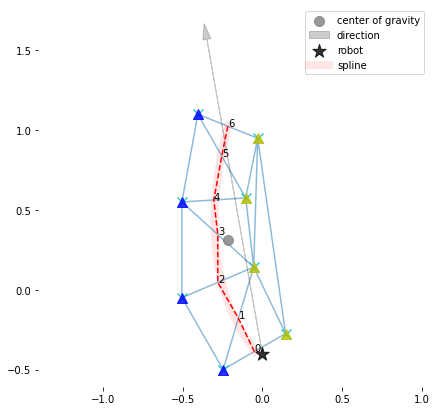

In [337]:
x1, y1 = 0, -0.4
origin = np.array([x1, y1])
yaw = np.deg2rad(100)
x2, y2 = np.mean(closest_points[:, 0]), np.mean(closest_points[:, 1]) # center of gravity of the 6 closest points
left_cone_indices = find_left_cones(np.array([0, -0.4]), yaw, np.array(closest_points))
right_cone_indices = [i for i in range(len(closest_points)) if i not in left_cone_indices]


# Voronoi diagram
# vor = Voronoi(closest_points)
# voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
# voronoi_points = np.array(vor.vertices)
# plt.plot(voronoi_points[:, 0], voronoi_points[:, 1], 'go', alpha=0.8)

# Delaunay triangulation
tri = Delaunay(closest_points)

midpoints = []
for i in range(len(tri.simplices)):
    # Do not add a midpoint that lies between two cones of the same type
    if (tri.simplices[i][0] in left_cone_indices and tri.simplices[i][1] in right_cone_indices) or (tri.simplices[i][0] in right_cone_indices and tri.simplices[i][1] in left_cone_indices):
        midpoints.append((closest_points[tri.simplices[i][0]] + closest_points[tri.simplices[i][1]]) / 2)
    if (tri.simplices[i][1] in left_cone_indices and tri.simplices[i][2] in right_cone_indices) or (tri.simplices[i][1] in right_cone_indices and tri.simplices[i][2] in left_cone_indices):
        midpoints.append((closest_points[tri.simplices[i][1]] + closest_points[tri.simplices[i][2]]) / 2)
    if (tri.simplices[i][2] in left_cone_indices and tri.simplices[i][0] in right_cone_indices) or (tri.simplices[i][2] in right_cone_indices and tri.simplices[i][0] in left_cone_indices):
        midpoints.append((closest_points[tri.simplices[i][2]] + closest_points[tri.simplices[i][0]]) / 2)

# remove duplicates
midpoints = np.unique(midpoints, axis=0)
midpoints = sort_by_nnb(midpoints, origin)
# orden the midpoints by nearest neighbor starting from the robot position
# midpoints = nearest_neighbor(midpoints, origin)
# orden the midpoints by nearest neighbor using the robot position as the first point and KDTree


# Plotting 
plt.triplot(closest_points[:, 0], closest_points[:, 1], tri.simplices.copy(), alpha=0.5)

for i, (x, y) in enumerate(midpoints):
    plt.text(x, y, str(i), fontsize=10)

plt.scatter(x2, y2, s=100, c='gray', marker='o', alpha=0.8, label='center of gravity')
plt.arrow(x1, y1, 2 * np.cos(yaw), 2 * np.sin(yaw), head_width=0.05, head_length=0.1, fc='k', ec='k', label='direction', alpha=0.2)
plt.plot(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], 'r--') # plot midpoints
plt.scatter(closest_points[:, 0], closest_points[:, 1], s=100, c='c', marker='x', alpha=0.8)
plt.scatter(x1, y1, s=200, c='k', marker='*', alpha=0.8, label='robot')

plt.scatter(np.array(closest_points)[left_cone_indices, 0], np.array(closest_points)[left_cone_indices, 1], s=100, c='b', marker='^', alpha=0.8)
plt.scatter(np.array(closest_points)[right_cone_indices, 0], np.array(closest_points)[right_cone_indices, 1], s=100, c='y', marker='^', alpha=0.8)

# fit b-spline through the midpoints
tck, u = splprep([np.array(midpoints)[:, 0], np.array(midpoints)[:, 1]], s=2)
u_new = np.linspace(u.min(), u.max(), 100)
x_new, y_new = splev(u_new, tck, der=0)
x_ext, y_ext = splev(u_new * 1.5, tck, der=0)

# extrapolate the b-spline further
plt.plot(x_new, y_new, 'r-', label='spline', alpha=0.1, linewidth=8)
plt.plot(x_ext, y_ext, 'r--', alpha=0.1, linewidth=8)

plt.legend()
plt.axis('equal')


In [ ]:
x1, y1 = 0, -0.4 # plot the 6 closest points
x2, y2 = np.mean(closest_points[:, 0]), np.mean(closest_points[:, 1]) # center of gravity of the 6 closest points


def find_lr_indices(points: np.ndarray):

    x1, y1 = 0.1, -0.5
    x2, y2 = 0, -0.4
    plt.plot([x1, x2], [y1, y2], 'ko-', alpha=0.7)  # plot origin line

    path = np.array([[x1, y1], [x2, y2]], dtype=np.float32, ndmin=2)

    for i in range(3):
        x1, y1 = path[-2, 0], path[-2, 1]
        x2, y2 = path[-1, 0], path[-1, 1]

        # angle formed by x1, y1, x2, y2
        angle1 = np.arctan2(y2 - y1, x2 - x1)

        # find the 3 closest points to the last point in the path
        distances = cdist(path[-1:], points)[0]
        closest_indices = np.array(np.argsort(distances)[:3])

        # find the 3 angles formed by the last point in the path and the 3 closest points
        angles = np.arctan2(points[closest_indices, 1] - path[-1, 1], points[closest_indices, 0] - path[-1, 0])
        print("The angles are: ", np.rad2deg(angles))

        # find the angle that is closest to the angle formed by x1, y1, x2, y2
        closest_angle_index = np.argmin(np.abs(angles - angle1))

        # check if the least angle point is not too close to the origin
        if np.linalg.norm(points[closest_indices[closest_angle_index]]) < 0.05:
            print("The point is too close to the origin")

        # add the point with the closest angle to the path
        path = np.append(path, [points[closest_indices[closest_angle_index]]], axis=0)
        # remove the point from the list of points
        points = np.delete(points, closest_indices[closest_angle_index], axis=0)

    # Plotting
    plt.scatter(points[closest_indices, 0], points[closest_indices, 1], s=200, c='darkblue', marker='2', alpha=0.8)
    plt.plot(path[:, 0], path[:, 1], 'r--', alpha=0.7)  # plot path


find_lr_indices(np.array(closest_points))


# enumerate the midpoints
for i, (x, y) in enumerate(midpoints):
    plt.text(x, y, str(i), fontsize=10)

# Plotting 
plt.scatter(x2, y2, s=100, c='gray', marker='o', alpha=0.8, label='center of gravity')
# plt.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.05, head_length=0.1, fc='k', ec='k', label='direction') # plot direction
plt.scatter(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], s=100, c='purple', marker='.') # plot midpoints
plt.scatter(closest_points[:, 0], closest_points[:, 1], s=100, c='c', marker='x', alpha=0.8)
# plt.scatter(x1, y1, s=100, c='k', marker='o', alpha=0.8)
plt.legend()
plt.axis('equal')

In [177]:
x1, y1 = 0.1, -0.5
x2, y2 = 0, -0.4
angle = np.arctan2(y2 - y1, x2 - x1)
print("The angle is: ", np.rad2deg(angle))

distances = cdist([[x2, y2]], closest_points)[0]
closest_indices = np.argsort(distances)[:2]
closest_2_points = closest_points[closest_indices]
print("The closest points are: ", closest_2_points)
# look which point stands on the left and which on the right side of the line (x1, y1) -> (x2, y2)
angles = np.arctan2(closest_2_points[:, 1] - y1, closest_2_points[:, 0] - x1)
print("The angles are: ", np.rad2deg(angles))

The angle is:  135.00000000000003
The closest points are:  [[ 0.1461012  -0.27499998]
 [-0.24556545 -0.49999998]]
The angles are:  [ 78.42069065 179.99999642]


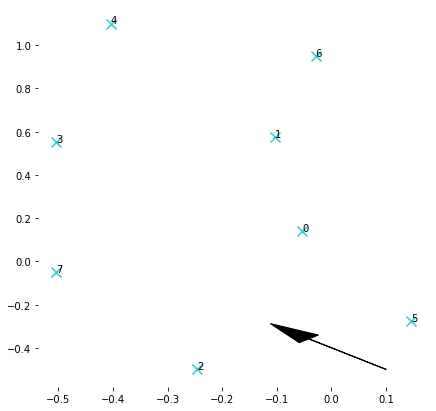

In [167]:
x1, y1 = 0.1, -0.5
x2, y2 = 0, -0.4
angle = np.arctan2(y2 - y1, x2 - x1)

points = closest_points[np.argsort(np.dot(points - [x2, y2], np.array([np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)])))]

plt.scatter(points[:, 0], points[:, 1], s=100, c='c', marker='x', alpha=0.8)

plt.arrow(x1, y1, 0.2 * np.cos(angle), 0.2 * np.sin(angle), head_width=0.05, head_length=0.1, fc='k', ec='k', label='direction')
# enumerate the points
for i, (x, y) in enumerate(points):
    plt.text(x, y, str(i), fontsize=10)

Nearest point: (-0.053898800164461136, 0.14166663425663995)


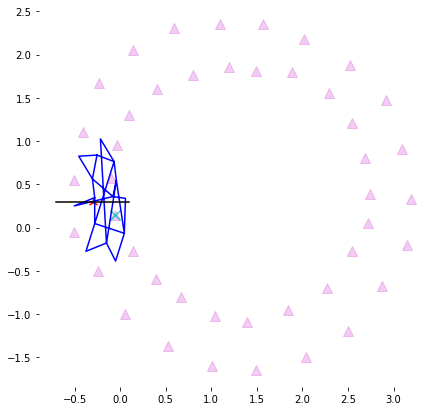

In [10]:
import numpy as np

# Define the line segment
p1 = line[0]
p2 = line[1]

# Define the set of points to compare against the line
points_set = centroids

# Find the nearest point(s) in the positive y-direction
nearest_point = None
min_distance = np.inf
for point in points_set:
    # Calculate the projection of the point onto the line segment
    v = p2 - p1
    w = point - p1
    proj = p1 + np.dot(w, v) / np.dot(v, v) * v
    
    # Check if the projection point lies on the line segment
    scalar_proj = np.dot(w, v) / np.dot(v, v)
    if scalar_proj >= 0 and scalar_proj <= 1:
        # Calculate the distance between the projection point and the original point
        distance = np.linalg.norm(proj - point)
        if distance < min_distance:
            nearest_point = point
            min_distance = distance

print("Nearest point:", nearest_point)


plt.plot(np.array(midpoints)[:, 0], np.array(midpoints)[:, 1], 'b-', label='polyline')
plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], s=100, c='m', marker='^', alpha=0.2)
plt.plot(line[:, 0], line[:, 1], 'k-', label='perpendicular line')
plt.scatter(origin[0], origin[1], s=100, c='r', marker='2')
plt.scatter(nearest_point[0], nearest_point[1], s=100, c='c', marker='x', alpha=0.8)


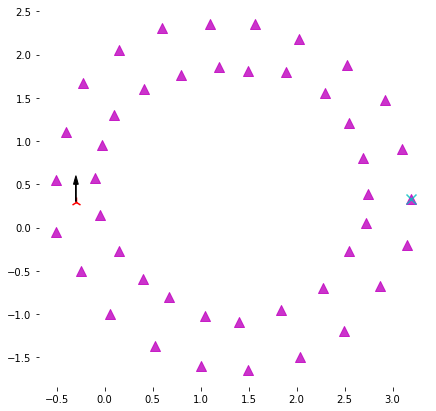

In [12]:
direction = np.deg2rad(90) + np.pi / 2

points2 = points[np.argsort(np.dot(points - origin, np.array([np.cos(direction), np.sin(direction)])))]

# plot the points
plt.scatter(points2[:, 0], points2[:, 1], s=100, c='m', marker='^', alpha=0.8)
# plot the origin
plt.scatter(origin[0], origin[1], s=100, c='r', marker='2')
# plot the unit vector
plt.arrow(origin[0], origin[1], 0.2 * np.cos(direction - np.pi/2), 0.2 * np.sin(direction- np.pi/2), head_width=0.05, head_length=0.1, fc='k', ec='k', label='direction')
# plot points2
plt.scatter(points2[0, 0], points2[0, 1], s=100, c='c', marker='x', alpha=0.8)

Implementing an algorithm to define the left and right lane cones and the midpoints between all the cone pairs.<br> 
The algorithm should start at a given origin searching for the two nearest points in the  +90 and -90 degrees range from the given direction.<br>
Once the two nearest points are found, it should repeat the process, starting from the midpoint of the two points, searching in the direction perpendicular to the line formed by the two points always in  a +90/-90 degrees range.<br>
The process should continue until the first midpoint is found again. <br>
The midpoints found should be stored in a list and returned, along with the indices of the left and right lane points. <br>
The algorithm mimic a robot navigating through a formula student circuit

In [14]:
# write a sweeping algorithm to return the left and right lane points
# the sweeping must be done in the given direction, this means it must firts search for the 2 nearest points +90 degrees from the direction and -90 degrees from the direction
# then when the 2 nearest points are found, it must repeat the process but starting from the midpoint of the 2 points and searching again but in the direction perpendicular to line formed by the 2 points
# the process must be repeated until the first midpoint is found again
# the midpoints found must be stored in a list and returned but also the indices of the left and right lane points must be returned

def track_recognitioning(points, origin, direction):
    """
    This function performs a sweeping algorithm to return the left and right lane indices and midpoints of the cone pairs.
    """
    


The voronoi points are:  [[ 0.40763307 -1.03833438]
 [ 2.57815541 -0.85680004]
 [ 2.1812032  -1.03845614]
 [ 1.26907987 -1.39885238]
 [ 2.86746514  1.14808059]
 [ 2.83482735  1.08702223]
 [ 1.36278775 -0.07218909]
 [ 1.37737727 -0.23788444]
 [ 1.17068141 -1.32303718]
 [ 0.73228542 -1.1230263 ]
 [ 0.85014099 -1.29980965]
 [ 2.13890542 -1.15551974]
 [ 1.70139714 -1.32024924]
 [ 1.70705727 -1.31135475]
 [ 2.94974873  0.20501766]
 [ 3.0031144   0.59444275]
 [ 2.95160305  0.62933753]
 [ 3.02411122  0.07886698]
 [ 2.56703953 -0.59001887]
 [ 1.90147762  0.28172044]
 [ 2.86037429 -0.35168437]
 [ 2.84468372 -0.22615977]
 [ 1.39989218  0.20788947]
 [ 1.50945011  0.09430369]
 [ 1.42145002  0.42572873]
 [ 2.61541942  1.56931823]
 [ 2.60859173  1.51242078]
 [ 2.19754232  1.90240187]
 [ 2.2036381   1.85439761]
 [ 1.71964317  2.06589363]
 [ 1.35087144  0.38296354]
 [ 1.34610122  0.41535081]
 [ 0.36761269 -0.91493821]
 [ 0.05938245 -0.65703124]
 [ 0.06848822 -0.59329093]
 [ 1.32987598  2.14182447]
 [ 

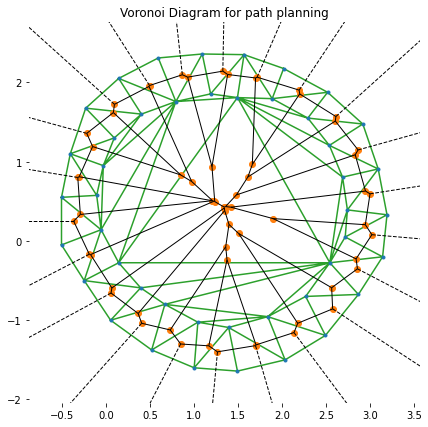

In [215]:
# plotting voronoi diagram for the centroids    
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(centroids)
voronoi_plot_2d(vor)

# get all the voronoi points
voronoi_points = vor.vertices

print("The voronoi points are: ", voronoi_points)

def nnb (points, point):
    """
    This function returns the nearest neighbour of a given point.
    """
    # calculate the distance between the given point and all the points in the list
    distances = cdist([point], points)[0]
    # get the index of the minimum distance
    min_index = np.argmin(distances)
    # return the nearest neighbour
    return points[min_index]
        



tri = Delaunay(centroids)


plt.triplot(np.array(centroids)[:, 0], np.array(centroids)[:, 1], tri.simplices.copy())


# plot delaunay triangulation
plt.title('Voronoi Diagram for path planning')
plt.show()

In [16]:
plt.plot(np.array(centerline)[:, 0], np.array(centerline)[:, 1], 'g--')
plt.plot(np.array(centerline)[:, 0], np.array(centerline)[:, 1], 'r*')

# # Plot a number next to each point
# for i, txt in enumerate(range(len(centerline))):
#     plt.annotate(txt, (centerline[i][0], centerline[i][1]))
    
# robot position and orientation
robot_pos = (3, .5)
robot_yaw = np.deg2rad(150)
plt.plot(robot_pos[0], robot_pos[1], 'm*')
plt.arrow(robot_pos[0], robot_pos[1], 0.1 * np.cos(robot_yaw), 0.1 * np.sin(robot_yaw), color='m', width=0.05, head_width=0.1)

# reorder the centerline to start from the robot position and orientation
centerline = np.array(centerline)
centerline = np.roll(centerline, -np.argmin(np.linalg.norm(centerline - robot_pos, axis=1)), axis=0)

# reverse the centerline order if the robot yaw is not in the same direction as the first centerline segment
if np.arctan2(centerline[1][1] - centerline[0][1], centerline[1][0] - centerline[0][0]) - robot_yaw > np.pi / 2:
    centerline = centerline[::-1]


for i, txt in enumerate(range(len(centerline))):
    plt.annotate(txt, (centerline[i][0], centerline[i][1]))

NameError: name 'centerline' is not defined

### Plotting Occupancy-grid

(-0.803898811340332,
 4.396101266145706,
 -1.9500000000000002,
 3.5500000819563864)

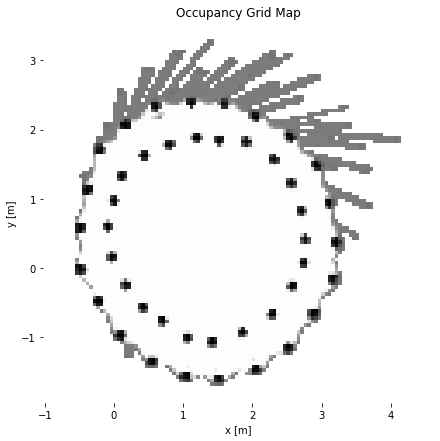

In [ ]:
# Plotting the map
fig_occupancy, ax = plt.subplots()
ax.imshow(map_data, cmap='gray', origin='lower', extent=extent)
ax.set_title('Occupancy Grid Map')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')

### Map values exploration

Total count of pixels:  11440
	 White pixels percentage (>99):  86.24125874125875 %
	 Gray pixels percentage (99>x>threshold) 11.04020979020979 %
	 Black pixels percentage (<threshold):  2.6486013986013983 %


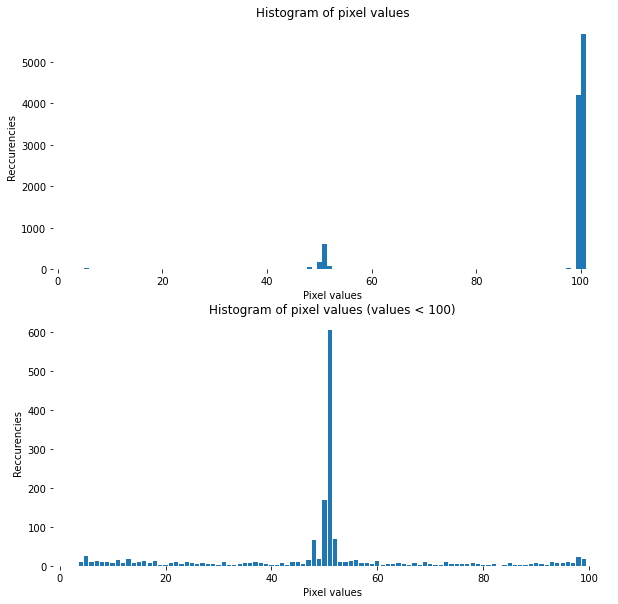

In [ ]:
threshold = 42
values, counts = np.unique(map_data, return_counts=True) 
values_counts = np.array([values, counts]).T

# Plotting the bar charts of pixel values and their reccurencies

fig_bar, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].hist(map_data.flatten(), bins=100)
ax[0].set_title('Histogram of pixel values')
ax[0].set_xlabel('Pixel values')
ax[0].set_ylabel('Reccurencies')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[1].bar(values_counts[values_counts[:,0]<100,0], values_counts[values_counts[:,0]<100,1])
ax[1].set_title('Histogram of pixel values (values < 100)')
ax[1].set_xlabel('Pixel values')
ax[1].set_ylabel('Reccurencies')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Printing the percentage of white, gray and black pixels
total_count = np.sum(counts)
print('Total count of pixels: ', total_count)
print('\t White pixels percentage (>99): ', np.sum(values_counts[values_counts[:,0]>99,1])/total_count*100, '%')
print('\t Gray pixels percentage (99>x>threshold)', np.sum(values_counts[(values_counts[:,0]>threshold) & (values_counts[:,0]<100),1])/total_count*100, '%')
print('\t Black pixels percentage (<threshold): ', np.sum(values_counts[values_counts[:,0]<threshold,1])/total_count*100, '%')

### Filtering the map
Keeping only peaks, which are represented with black pixels (value near zero)

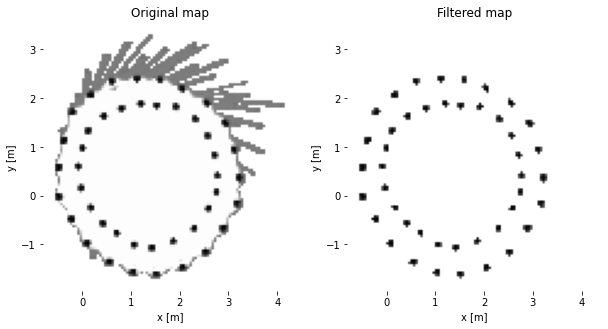

In [ ]:
# import cv2
# # Thresholding the map
# map_data_filtered = map_data.copy().astype(np.uint8)
# map_data_filtered = cv2.threshold(map_data_filtered, threshold, white, cv2.THRESH_BINARY)[1]
# # Plotting both original and filtered map
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(map_data, cmap='gray', origin='lower', extent=extent)
# ax[0].set_title('Original map')
# ax[1].imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
# ax[1].set_title('Filtered map')

# Dark gray values on the map are close to 0 and represent the cones on the map
threshold ,white = 42, 101
map_data_filtered = map_data.copy()
map_data_filtered[map_data > threshold] = white

# Plotting both original and filtered map
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(map_data, cmap='gray', origin='lower', extent=extent)
ax[0].set_title('Original map')
ax[0].set_xlabel('x [m]'), ax[0].set_ylabel('y [m]')
ax[1].imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
ax[1].set_title('Filtered map')
ax[1].set_xlabel('x [m]'), ax[1].set_ylabel('y [m]')

## Clustering

### Meansshift clustering
Mean-shift clustering is a non-parametric, density-based clustering algorithm that can be used to identify clusters in a dataset.

Time elapsed:  0.22761964797973633 s
Number of estimated clusters:  44


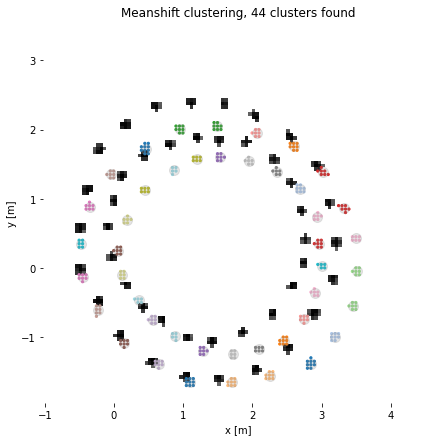

In [ ]:
# Getting the cartesian coordinates of the black pixels
x, y = np.where(map_data < threshold)
x, y = (x*resolution + xorigin, y*resolution + yorigin)
points = np.array([x, y]).T

# Meanshift clustering
start = time.time()
bandwidth = estimate_bandwidth(points, quantile=0.025, n_samples=80)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
end = time.time()
print('Time elapsed: ', end-start, 's')

# Plotting the results
fig, ax = plt.subplots()
ax.imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
ax.scatter(points[:,0], points[:,1], c=labels, s=5, cmap='tab20')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], c='gray', marker='o', s=100, alpha=0.2)
ax.set_title('Meanshift clustering, %i clusters found' % len(np.unique(labels)))
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')

# Printing the number of clusters
n_clusters_ = len(np.unique(labels))
print('Number of estimated clusters: ', n_clusters_)

### DBSCAN

Time execution:  0.5421333312988281
Number of estimated clusters:  44


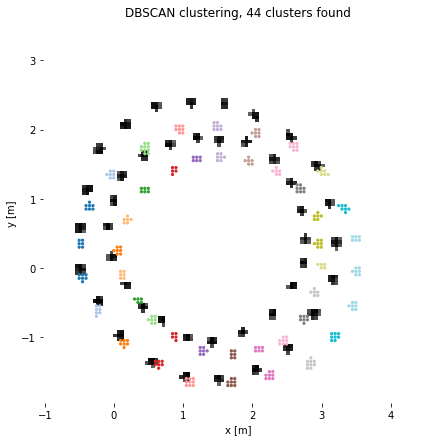

In [ ]:
# DBSCAN clustering
start = time.time()
db = DBSCAN(eps=0.1, min_samples=3).fit(points)
labels = db.labels_
end = time.time()
print('Time execution: ', end - start)

# Plotting the results
fig, ax = plt.subplots()
ax.imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
ax.scatter(points[:,0], points[:,1], c=labels, s=5, cmap='tab20')
ax.set_title('DBSCAN clustering, %i clusters found' % len(set(labels)))
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')

# Printing the number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of estimated clusters: ', n_clusters_)


### Contouring technique

Number of centroids found:  44


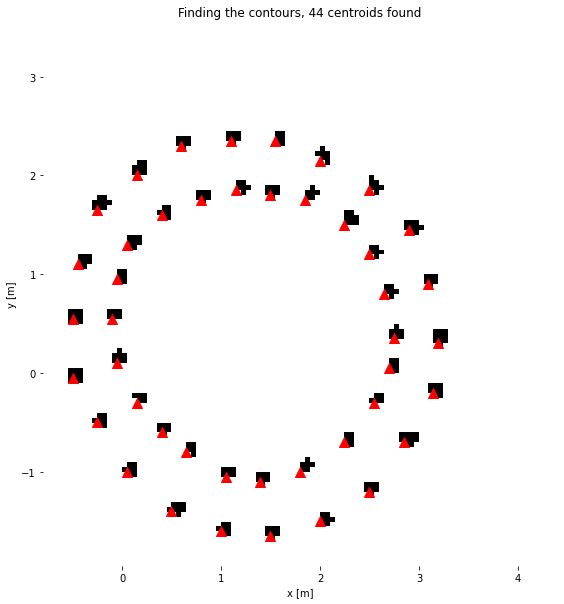

In [ ]:
# Finding the centroids 
map_data_t = cv2.threshold(map_data.astype(np.uint8), threshold, white, cv2.THRESH_BINARY)[1]
contours, hierarchy = cv2.findContours(map_data_t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[1:]
centroids = []

for i in range(len(contours)):
    M = cv2.moments(contours[i])
    cx = int(M['m10']/M['m00']) * resolution + xorigin
    cy = int(M['m01']/M['m00']) * resolution + yorigin
    centroids.append([cx, cy])

# Plotting the centroids
fig_centroids, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent)
ax.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], c='r', marker='^', s=100)
ax.set_title('Finding the contours, %i centroids found' % len(contours))
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')

# Printing the number of centroids found
print('Number of centroids found: ', len(contours))

#### Blob-detection

In [ ]:
# Using blob detection to find the centroids

params = cv2.SimpleBlobDetector_Params()

# Changing thresholds
params.minThreshold = 0
params.maxThreshold = 42

# Filtering by Area.
params.filterByArea = True
params.minArea = 100

# Filtering by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filtering by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filtering by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params) 
keypoints = detector.detect(map_data.astype(np.uint8)) 

# Plotting the keypoints
keypoints

()

## Track definition

Nearest neighbours, convexhulls, curve fitting? 

### Connecting the 3 nearest neighbours


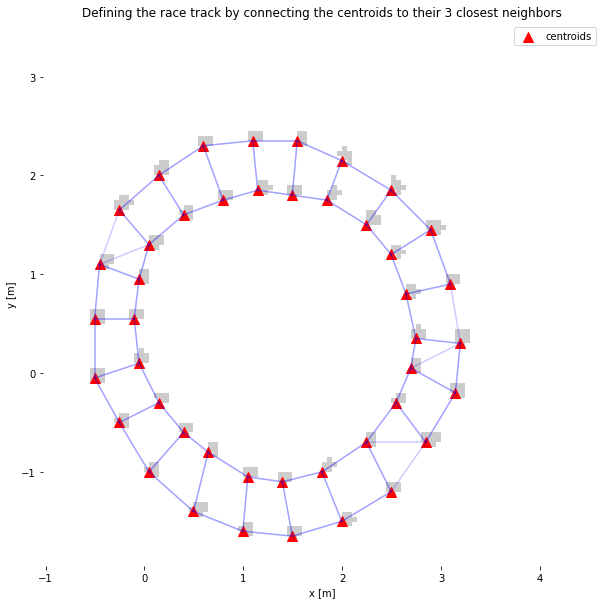

In [ ]:
from scipy.spatial.distance import cdist

distances = cdist(centroids, centroids)

# Setting the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# Finding the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], c='r', marker='^', s=100, label='centroids')
for i in range(len(centroids)):
    for j in range(3):
        ax.plot([centroids[i][0], centroids[closest_centroids[i][j]][0]], [centroids[i][1], centroids[closest_centroids[i][j]][1]], 'b', alpha=0.2)
ax.set_title('Defining the race track by connecting the centroids to their 3 closest neighbors')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

### Nearest neighbours and greatest angles

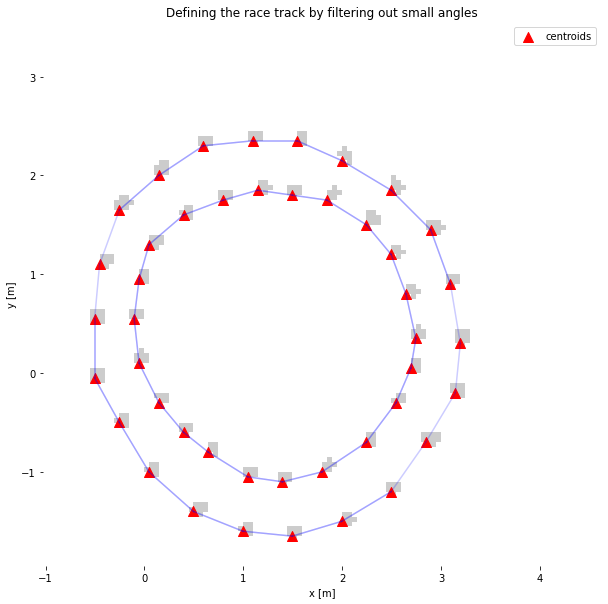

In [ ]:
centroids = np.array(centroids) # convert centroids list to numpy array
distances = cdist(centroids, centroids)

# set the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# find the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='^', s=100, label='centroids')

for i in range(len(centroids)):
    angles = []
    for j in range(3):
        vec1 = centroids[closest_centroids[i][j]] - centroids[i]
        vec2 = centroids[closest_centroids[i][(j+1)%3]] - centroids[i]
        # calculate angle between the two vectors
        angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
        angles.append(angle)
    # get index of maximum angle
    max_angle_idx = np.argmax(angles)
    # plot line corresponding to the maximum angle
    if angles[max_angle_idx] >= np.deg2rad(130):
        ax.plot([centroids[i][0], centroids[closest_centroids[i][max_angle_idx]][0]], [centroids[i][1], centroids[closest_centroids[i][max_angle_idx]][1]], 'b', alpha=0.2)
        
        # remove the point that was already used for the first line
        other_points = np.delete(centroids[closest_centroids[i]], max_angle_idx, axis=0)

        # calculate angles between the remaining points and the first line
        angles_to_first_line = []
        for j in range(2):
            vec1 = other_points[j] - centroids[i]
            vec2 = centroids[closest_centroids[i][max_angle_idx]] - centroids[i]
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles_to_first_line.append(angle)
        # get index of maximum angle
        max_angle_idx = np.argmax(angles_to_first_line)
        # plot line corresponding to the maximum angle
        if angles_to_first_line[max_angle_idx] >= np.deg2rad(100):
            ax.plot([centroids[i][0], other_points[max_angle_idx][0]], [centroids[i][1], other_points[max_angle_idx][1]], 'b', alpha=0.2)

ax.set_title('Defining the race track by filtering out small angles')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

### Convex Hulls

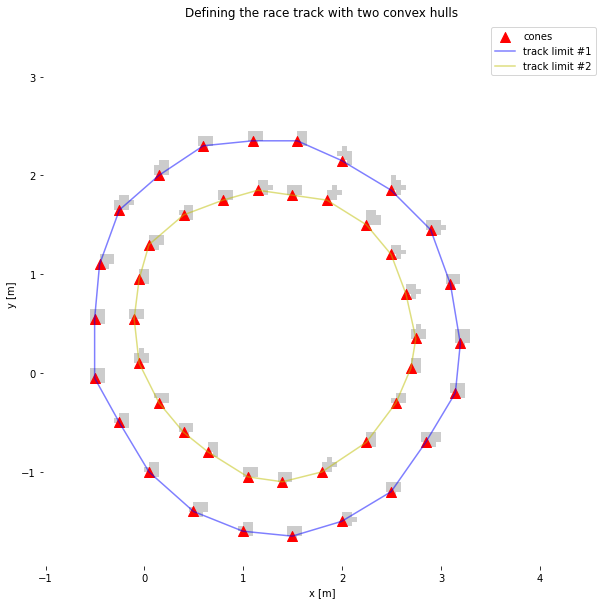

In [ ]:
centroids = np.array(centroids) # converting centroids list to numpy array
distances = cdist(centroids, centroids)

# setting the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# finding the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='^', s=100, label='cones')

# first convex hull with all the centroids
hull_all = ConvexHull(centroids)

# getting the indices of the points that form the convex hull
hull_indices_all = hull_all.vertices.tolist()
# add the first point to the end to close the loop
hull_indices_all.append(hull_indices_all[0])

# plotting the first convex hull
ax.plot(centroids[hull_indices_all, 0], centroids[hull_indices_all, 1], 'b', alpha=0.5, label='track limit #1')

# get the indices of the points not included in the first convex hull
remaining_indices = np.setdiff1d(np.arange(len(centroids)), hull_indices_all[:-1])

# second convex hull with the remaining centroids
hull_remaining = ConvexHull(centroids[remaining_indices])

# getting the indices of the points that form the second convex hull
hull_indices_remaining = remaining_indices[hull_remaining.vertices].tolist()
# adding the first point to the end to close the loop
hull_indices_remaining.append(hull_indices_remaining[0])

# plotting the second convex hull
ax.plot(centroids[hull_indices_remaining, 0], centroids[hull_indices_remaining, 1], 'y', alpha=0.5, label='track limit #2')

ax.set_title('Defining the race track with two convex hulls')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

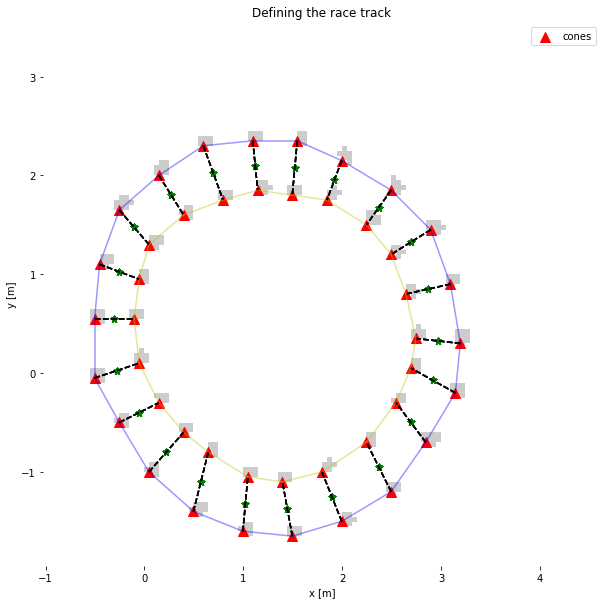

In [ ]:
centroids = np.array(centroids) # convert centroids list to numpy array
distances = cdist(centroids, centroids)

# set the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# find the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='^', s=100, label='cones')

# perform convex hull on all centroids
hull = ConvexHull(centroids)
for simplex in hull.simplices:
    ax.plot(centroids[simplex, 0], centroids[simplex, 1], 'b', alpha=0.4)

# find centroids not in the first hull
not_in_hull = centroids[~np.in1d(np.arange(len(centroids)), hull.vertices)]
# perform convex hull on centroids not in the first hull
hull2 = ConvexHull(not_in_hull)
for simplex in hull2.simplices:
    ax.plot(not_in_hull[simplex, 0], not_in_hull[simplex, 1], 'y', alpha=0.4)

    # plot dotted line between the two hulls
    for v in hull.vertices:
        # find closest point in second hull
        closest_point_idx = np.argmin(np.linalg.norm(not_in_hull - centroids[v], axis=1))
        # plot dotted line
        ax.plot([centroids[v][0], not_in_hull[closest_point_idx][0]], [centroids[v][1], not_in_hull[closest_point_idx][1]], 'k--', alpha=0.2)
        # and plot the midpoint of the line
        ax.scatter((centroids[v][0] + not_in_hull[closest_point_idx][0]) / 2, (centroids[v][1] + not_in_hull[closest_point_idx][1]) / 2, c='g', marker='*', s=50)

ax.set_title('Defining the race track')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

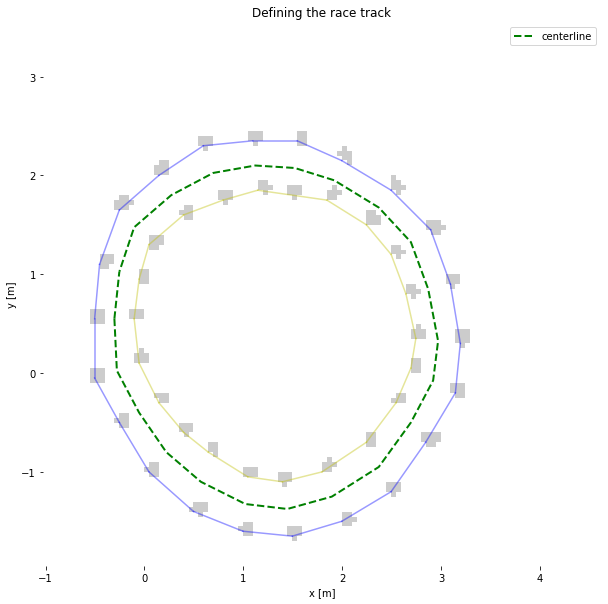

In [ ]:
# import polygon class
from matplotlib.patches import Polygon

# calculate the centerline between the two hulls
centerline = []
for i in range(len(hull.vertices)):
    p1 = centroids[hull.vertices[i]]
    p2 = not_in_hull[np.argmin(np.linalg.norm(not_in_hull - p1, axis=1))]
    centerline.append((p1 + p2) / 2)

centerline = np.array(centerline)

# plot the costmap
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)

# plot the track limits
for simplex in hull.simplices:
    ax.plot(centroids[simplex, 0], centroids[simplex, 1], 'b', alpha=0.4)
for simplex in hull2.simplices:
    ax.plot(not_in_hull[simplex, 0], not_in_hull[simplex, 1], 'y', alpha=0.4)

# plot the centerline
ax.plot(centerline[:, 0], centerline[:, 1], 'g--', linewidth=2)
# close the loop of the centerline
ax.plot([centerline[0, 0], centerline[-1, 0]], [centerline[0, 1], centerline[-1, 1]], 'g--', linewidth=2, label='centerline')

ax.set_title('Defining the race track')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()